## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

## Reading in Training Data from CSVs

In [3]:
# Reading in the training data from the given CSV file.
training_data = pd.read_csv('training.csv')
# Printing the shape of the training data. This shows the training data has 247 dimensions and each dimension having 4610 elements
print("Training data dimensions: ", training_data.shape)
# Reading in the additional training data provided from the CSV
add_data = pd.read_csv('additional_training.csv')
# Printing the shape of the additional training data. Shows us the additional training data has 2219 dimensions, each with 4610 elements
print("Additional training data dimensions: ", add_data.shape)

Training data dimensions:  (247, 4610)
Additional training data dimensions:  (2219, 4610)


## Combining Training datas

In [4]:
# Concat method combines the training data and the additional training data together, giving a combined (247+2219) = 2466 Dimensions each with 4610 elements
all_training_data = pd.concat([training_data,add_data], axis=0)
print("All combined training data dimensions: ", all_training_data.shape)

# Train y has 2466 dimensions all with only 1 element, prediction, shown in shape.
train_y = all_training_data[['prediction']]
# Train x drops labels in requested axis, i.e. prediction & ID, removed. Now has 2 less elements per dimension as all combined training data.
train_x = all_training_data.drop('prediction', axis=1)
train_x = train_x.drop('ID', axis=1)
print("Train Y shape: ", train_y.shape, ", Train X shape: ", train_x.shape)

All combined training data dimensions:  (2466, 4610)
Train Y shape:  (2466, 1) , Train X shape:  (2466, 4608)


## Using a Simple Imputer, all NaN values replaced

In [5]:
# Create Imputer, which replaces values of NaN (Not a Number), replace missing values using the mean along each column.
# This is the best stratedy as median & most frequent would not work due to the large class imbalance.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
replaced_data = imp.fit_transform(train_x)
# Wouldnt effect the shape as previous values have been updated, not gotten rid of.
train_x = replaced_data

## Reading in Testing Data

In [6]:
# Reading in & displaying the shape of the testing data. 11874 dimensions each with 4609 elements
testing_data = pd.read_csv('testing.csv')
print("Testing data dimensions: ", testing_data.shape)
# Cleaing up the test data (dropping the element), so both training & testing have 4608 Elements
test_x = testing_data.drop('ID', axis=1)
print("Testing data dimensions after dropping Column 'ID': ", test_x.shape)

Testing data dimensions:  (11874, 4609)
Testing data dimensions after dropping Column 'ID':  (11874, 4608)


## Testing a SVC before any Pre-processing / Feature Selection / Exhaustive Grid Search

In [7]:
# Creates an SVC with default values, and a C value of 0.5 (Half the default value.)
svc1 = SVC(kernel='linear')
# Fits the classifier using the training data
svc1.fit(train_x, train_y.values)
# Creates predictions of the test data.
predicts = svc1.predict(test_x)
# Score method Return the mean accuracy on the given test data and labels.
# Prints the score of the predictions
print(svc1.score(test_x,predicts))

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0


In [8]:
# Loops through all predictions, printing out how many are memorable, and how many are non-memorable.
# This is then compared to the proportions specified in the testing proportions file
counts = 0
for item in predicts:
    if item == 0:
        counts += 1
print("non-memorable:", counts/len(predicts))
print("memorable:", 1-counts/len(predicts))
# As shown by the results, the classier has given all testing data the class memorable. This is not effective, as 
# The test proportions document states that only ~39% of the data should be classed as memorable.

non-memorable: 0.4009600808489136
memorable: 0.5990399191510865


## Pre-Processing: Scaling

In [9]:
# Transform features by scaling each feature to a given range.
# This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Default range is 0 & 1, which is for binary classification!
minMax = MinMaxScaler()
train_x = minMax.fit_transform(train_x)
test_x = minMax.transform(test_x)
# Possibly should have used a better Pre-processing method in hindsight.

## Feature Selection: PCA

In [10]:
# Prncipal component analysis (PCA).
# Linear dimensionality reduction using Singular Value Decomposition (SVD) of the data to project it to a lower dimensional space. 
# The input data is centered but not scaled for each feature before applying the SVD.

pca = PCA(n_components = 1600)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

## Exhaustive Grid Search: Parameter Testing

In [15]:
# Parameters to combine & test
parameters = {'C': [0.05, 0.1, 0.5, 1, 10, 100], 'class_weight': ['balanced', None], 'cache_size': [200, 500, 1000], 'gamma':['scale', 10, 100, 500], 'kernel': ['linear', 'poly']} 
# Running grid search using parameters specified above
gs = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose = 10) #running grid search using parameters specified above
# Fitting the training data
gs.fit(train_x,train_y)
# Returning best parameters for MLP CLassifier
print(gs.best_params_)

F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Paralle

{'C': 0.05, 'cache_size': 200, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'}


## Creating the Classifier with Best Parameters & Making predictions

In [11]:
# Creates SVC using best parameters specified in Grid Search
# Even though Poly has returned as better, lower CV score and worse off on test-proportions
svc = SVC(kernel='linear', C=0.05, gamma='scale')
svc.fit(train_x, train_y.values)

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [12]:
# Calculate predictions and save in preds
preds = svc.predict(test_x)
print(svc.score(test_x,preds))

1.0


In [13]:
# Loops through all predictions, printing out how many are memorable, and how many are non-memorable.
# This is then compared to the proportions specified in the testing proportions file
count = 0
for item in preds:
    if item == 0:
        count += 1
print("non-memorable:", count/len(preds))
print("memorable:", 1-count/len(preds))

non-memorable: 0.364914940205491
memorable: 0.635085059794509


## Cross-Validation score for parameter C

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................ C=0.0001, score=0.866, total=   3.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................ C=0.0001, score=0.868, total=   3.5s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................ C=0.0001, score=0.868, total=   3.6s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................ C=0.0001, score=0.868, total=   3.5s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.9s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............................ C=0.0001, score=0.868, total=   3.5s
[CV] C=0.00013433993325989 ...........................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.5s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.00013433993325989, score=0.866, total=   3.7s
[CV] C=0.00013433993325989 ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   21.2s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.00013433993325989, score=0.868, total=   3.7s
[CV] C=0.00013433993325989 ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.8s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.00013433993325989, score=0.868, total=   3.6s
[CV] C=0.00013433993325989 ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.5s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.00013433993325989, score=0.868, total=   3.6s
[CV] C=0.00013433993325989 ...........................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.1s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.00013433993325989, score=0.868, total=   3.7s
[CV] C=0.00018047217668271703 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00018047217668271703, score=0.866, total=   3.7s
[CV] C=0.00018047217668271703 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00018047217668271703, score=0.868, total=   3.8s
[CV] C=0.00018047217668271703 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00018047217668271703, score=0.868, total=   3.7s
[CV] C=0.00018047217668271703 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00018047217668271703, score=0.868, total=   3.7s
[CV] C=0.00018047217668271703 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00018047217668271703, score=0.868, total=   3.8s
[CV] C=0.00024244620170823283 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00024244620170823283, score=0.866, total=   4.1s
[CV] C=0.00024244620170823283 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00024244620170823283, score=0.868, total=   4.4s
[CV] C=0.00024244620170823283 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00024244620170823283, score=0.868, total=   4.2s
[CV] C=0.00024244620170823283 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00024244620170823283, score=0.868, total=   4.4s
[CV] C=0.00024244620170823283 ........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............ C=0.00024244620170823283, score=0.868, total=   4.0s
[CV] C=0.0003257020655659783 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0003257020655659783, score=0.866, total=   3.9s
[CV] C=0.0003257020655659783 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0003257020655659783, score=0.868, total=   4.0s
[CV] C=0.0003257020655659783 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0003257020655659783, score=0.868, total=   4.1s
[CV] C=0.0003257020655659783 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0003257020655659783, score=0.868, total=   4.1s
[CV] C=0.0003257020655659783 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0003257020655659783, score=0.868, total=   4.1s
[CV] C=0.0004375479375074184 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0004375479375074184, score=0.866, total=   3.9s
[CV] C=0.0004375479375074184 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0004375479375074184, score=0.868, total=   4.1s
[CV] C=0.0004375479375074184 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0004375479375074184, score=0.868, total=   4.5s
[CV] C=0.0004375479375074184 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0004375479375074184, score=0.868, total=   4.1s
[CV] C=0.0004375479375074184 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0004375479375074184, score=0.868, total=   4.0s
[CV] C=0.0005878016072274912 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0005878016072274912, score=0.866, total=   4.0s
[CV] C=0.0005878016072274912 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0005878016072274912, score=0.868, total=   4.1s
[CV] C=0.0005878016072274912 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0005878016072274912, score=0.868, total=   4.0s
[CV] C=0.0005878016072274912 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0005878016072274912, score=0.868, total=   4.0s
[CV] C=0.0005878016072274912 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0005878016072274912, score=0.868, total=   4.1s
[CV] C=0.0007896522868499724 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0007896522868499724, score=0.866, total=   4.0s
[CV] C=0.0007896522868499724 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0007896522868499724, score=0.868, total=   4.1s
[CV] C=0.0007896522868499724 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0007896522868499724, score=0.868, total=   4.0s
[CV] C=0.0007896522868499724 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0007896522868499724, score=0.868, total=   4.1s
[CV] C=0.0007896522868499724 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0007896522868499724, score=0.868, total=   4.1s
[CV] C=0.0010608183551394483 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0010608183551394483, score=0.866, total=   4.1s
[CV] C=0.0010608183551394483 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0010608183551394483, score=0.868, total=   4.3s
[CV] C=0.0010608183551394483 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0010608183551394483, score=0.868, total=   4.4s
[CV] C=0.0010608183551394483 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0010608183551394483, score=0.868, total=   4.0s
[CV] C=0.0010608183551394483 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0010608183551394483, score=0.868, total=   4.0s
[CV] C=0.0014251026703029977 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0014251026703029977, score=0.866, total=   4.0s
[CV] C=0.0014251026703029977 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0014251026703029977, score=0.868, total=   4.2s
[CV] C=0.0014251026703029977 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0014251026703029977, score=0.868, total=   4.2s
[CV] C=0.0014251026703029977 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0014251026703029977, score=0.868, total=   4.0s
[CV] C=0.0014251026703029977 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0014251026703029977, score=0.868, total=   4.1s
[CV] C=0.0019144819761699576 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0019144819761699576, score=0.866, total=   4.1s
[CV] C=0.0019144819761699576 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0019144819761699576, score=0.868, total=   4.3s
[CV] C=0.0019144819761699576 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0019144819761699576, score=0.868, total=   4.1s
[CV] C=0.0019144819761699576 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0019144819761699576, score=0.868, total=   4.0s
[CV] C=0.0019144819761699576 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0019144819761699576, score=0.868, total=   4.0s
[CV] C=0.0025719138090593446 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0025719138090593446, score=0.866, total=   4.0s
[CV] C=0.0025719138090593446 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0025719138090593446, score=0.868, total=   4.2s
[CV] C=0.0025719138090593446 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0025719138090593446, score=0.868, total=   4.1s
[CV] C=0.0025719138090593446 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0025719138090593446, score=0.868, total=   4.0s
[CV] C=0.0025719138090593446 .........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............. C=0.0025719138090593446, score=0.868, total=   4.0s
[CV] C=0.003455107294592218 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.003455107294592218, score=0.866, total=   4.1s
[CV] C=0.003455107294592218 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.003455107294592218, score=0.868, total=   4.2s
[CV] C=0.003455107294592218 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.003455107294592218, score=0.868, total=   4.0s
[CV] C=0.003455107294592218 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.003455107294592218, score=0.868, total=   4.0s
[CV] C=0.003455107294592218 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.003455107294592218, score=0.868, total=   4.0s
[CV] C=0.004641588833612777 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.004641588833612777, score=0.866, total=   4.0s
[CV] C=0.004641588833612777 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.004641588833612777, score=0.868, total=   4.2s
[CV] C=0.004641588833612777 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.004641588833612777, score=0.868, total=   4.2s
[CV] C=0.004641588833612777 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.004641588833612777, score=0.868, total=   4.0s
[CV] C=0.004641588833612777 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.004641588833612777, score=0.868, total=   4.1s
[CV] C=0.006235507341273912 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.006235507341273912, score=0.866, total=   4.1s
[CV] C=0.006235507341273912 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.006235507341273912, score=0.868, total=   4.2s
[CV] C=0.006235507341273912 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.006235507341273912, score=0.868, total=   4.0s
[CV] C=0.006235507341273912 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.006235507341273912, score=0.868, total=   4.0s
[CV] C=0.006235507341273912 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.006235507341273912, score=0.868, total=   4.1s
[CV] C=0.008376776400682916 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.008376776400682916, score=0.866, total=   4.1s
[CV] C=0.008376776400682916 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.008376776400682916, score=0.868, total=   4.1s
[CV] C=0.008376776400682916 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.008376776400682916, score=0.868, total=   5.0s
[CV] C=0.008376776400682916 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.008376776400682916, score=0.868, total=   4.3s
[CV] C=0.008376776400682916 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.008376776400682916, score=0.868, total=   4.5s
[CV] C=0.011253355826007646 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.011253355826007646, score=0.866, total=   4.1s
[CV] C=0.011253355826007646 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.011253355826007646, score=0.868, total=   4.1s
[CV] C=0.011253355826007646 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.011253355826007646, score=0.868, total=   4.5s
[CV] C=0.011253355826007646 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.011253355826007646, score=0.868, total=   4.2s
[CV] C=0.011253355826007646 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.011253355826007646, score=0.868, total=   4.2s
[CV] C=0.015117750706156615 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.015117750706156615, score=0.866, total=   4.2s
[CV] C=0.015117750706156615 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.015117750706156615, score=0.868, total=   4.4s
[CV] C=0.015117750706156615 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.015117750706156615, score=0.868, total=   4.1s
[CV] C=0.015117750706156615 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.015117750706156615, score=0.868, total=   4.1s
[CV] C=0.015117750706156615 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.015117750706156615, score=0.868, total=   4.2s
[CV] C=0.020309176209047347 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.020309176209047347, score=0.866, total=   4.3s
[CV] C=0.020309176209047347 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.020309176209047347, score=0.868, total=   4.5s
[CV] C=0.020309176209047347 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.020309176209047347, score=0.868, total=   4.2s
[CV] C=0.020309176209047347 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.020309176209047347, score=0.868, total=   4.1s
[CV] C=0.020309176209047347 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.020309176209047347, score=0.868, total=   4.2s
[CV] C=0.027283333764867666 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.027283333764867666, score=0.864, total=   4.5s
[CV] C=0.027283333764867666 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.027283333764867666, score=0.868, total=   4.5s
[CV] C=0.027283333764867666 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.027283333764867666, score=0.868, total=   4.3s
[CV] C=0.027283333764867666 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.027283333764867666, score=0.866, total=   4.1s
[CV] C=0.027283333764867666 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.027283333764867666, score=0.868, total=   4.1s
[CV] C=0.03665241237079626 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.03665241237079626, score=0.866, total=   4.5s
[CV] C=0.03665241237079626 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.03665241237079626, score=0.870, total=   4.1s
[CV] C=0.03665241237079626 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.03665241237079626, score=0.868, total=   3.9s
[CV] C=0.03665241237079626 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.03665241237079626, score=0.866, total=   3.9s
[CV] C=0.03665241237079626 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.03665241237079626, score=0.866, total=   3.9s
[CV] C=0.049238826317067365 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.049238826317067365, score=0.856, total=   4.0s
[CV] C=0.049238826317067365 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.049238826317067365, score=0.870, total=   4.1s
[CV] C=0.049238826317067365 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.049238826317067365, score=0.866, total=   4.0s
[CV] C=0.049238826317067365 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.049238826317067365, score=0.860, total=   4.0s
[CV] C=0.049238826317067365 ..........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............. C=0.049238826317067365, score=0.864, total=   3.9s
[CV] C=0.06614740641230146 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.06614740641230146, score=0.850, total=   3.9s
[CV] C=0.06614740641230146 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.06614740641230146, score=0.864, total=   4.4s
[CV] C=0.06614740641230146 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.06614740641230146, score=0.862, total=   4.2s
[CV] C=0.06614740641230146 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.06614740641230146, score=0.856, total=   4.1s
[CV] C=0.06614740641230146 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.06614740641230146, score=0.854, total=   4.2s
[CV] C=0.08886238162743398 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.08886238162743398, score=0.832, total=   4.1s
[CV] C=0.08886238162743398 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.08886238162743398, score=0.850, total=   4.2s
[CV] C=0.08886238162743398 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.08886238162743398, score=0.840, total=   4.1s
[CV] C=0.08886238162743398 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.08886238162743398, score=0.844, total=   4.1s
[CV] C=0.08886238162743398 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.08886238162743398, score=0.836, total=   4.2s
[CV] C=0.11937766417144358 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.11937766417144358, score=0.820, total=   4.1s
[CV] C=0.11937766417144358 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.11937766417144358, score=0.828, total=   4.2s
[CV] C=0.11937766417144358 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.11937766417144358, score=0.819, total=   4.2s
[CV] C=0.11937766417144358 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.11937766417144358, score=0.830, total=   4.2s
[CV] C=0.11937766417144358 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.11937766417144358, score=0.817, total=   4.1s
[CV] C=0.16037187437513292 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.16037187437513292, score=0.812, total=   4.0s
[CV] C=0.16037187437513292 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.16037187437513292, score=0.809, total=   4.1s
[CV] C=0.16037187437513292 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.16037187437513292, score=0.805, total=   4.1s
[CV] C=0.16037187437513292 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.16037187437513292, score=0.809, total=   4.0s
[CV] C=0.16037187437513292 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.16037187437513292, score=0.793, total=   4.2s
[CV] C=0.21544346900318823 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.21544346900318823, score=0.791, total=   4.1s
[CV] C=0.21544346900318823 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.21544346900318823, score=0.781, total=   4.1s
[CV] C=0.21544346900318823 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.21544346900318823, score=0.793, total=   4.0s
[CV] C=0.21544346900318823 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.21544346900318823, score=0.781, total=   4.0s
[CV] C=0.21544346900318823 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.21544346900318823, score=0.779, total=   4.0s
[CV] C=0.2894266124716749 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.2894266124716749, score=0.785, total=   4.1s
[CV] C=0.2894266124716749 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.2894266124716749, score=0.763, total=   4.0s
[CV] C=0.2894266124716749 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.2894266124716749, score=0.779, total=   4.0s
[CV] C=0.2894266124716749 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.2894266124716749, score=0.779, total=   4.0s
[CV] C=0.2894266124716749 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.2894266124716749, score=0.767, total=   4.1s
[CV] C=0.38881551803080855 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.38881551803080855, score=0.779, total=   4.0s
[CV] C=0.38881551803080855 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.38881551803080855, score=0.753, total=   3.9s
[CV] C=0.38881551803080855 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.38881551803080855, score=0.771, total=   4.0s
[CV] C=0.38881551803080855 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.38881551803080855, score=0.783, total=   3.9s
[CV] C=0.38881551803080855 ...........................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ............... C=0.38881551803080855, score=0.757, total=   4.0s
[CV] C=0.5223345074266837 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.5223345074266837, score=0.765, total=   3.9s
[CV] C=0.5223345074266837 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.5223345074266837, score=0.751, total=   4.0s
[CV] C=0.5223345074266837 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.5223345074266837, score=0.763, total=   4.9s
[CV] C=0.5223345074266837 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.5223345074266837, score=0.779, total=   4.7s
[CV] C=0.5223345074266837 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.5223345074266837, score=0.761, total=   4.6s
[CV] C=0.7017038286703823 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.7017038286703823, score=0.763, total=   4.6s
[CV] C=0.7017038286703823 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.7017038286703823, score=0.746, total=   4.1s
[CV] C=0.7017038286703823 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.7017038286703823, score=0.746, total=   4.6s
[CV] C=0.7017038286703823 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.7017038286703823, score=0.771, total=   4.9s
[CV] C=0.7017038286703823 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.7017038286703823, score=0.757, total=   4.6s
[CV] C=0.9426684551178844 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.9426684551178844, score=0.763, total=   4.6s
[CV] C=0.9426684551178844 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.9426684551178844, score=0.753, total=   4.6s
[CV] C=0.9426684551178844 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.9426684551178844, score=0.744, total=   5.0s
[CV] C=0.9426684551178844 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.9426684551178844, score=0.775, total=   4.6s
[CV] C=0.9426684551178844 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=0.9426684551178844, score=0.757, total=   4.7s
[CV] C=1.2663801734674023 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.2663801734674023, score=0.763, total=   4.8s
[CV] C=1.2663801734674023 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.2663801734674023, score=0.753, total=   4.7s
[CV] C=1.2663801734674023 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.2663801734674023, score=0.744, total=   4.8s
[CV] C=1.2663801734674023 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.2663801734674023, score=0.775, total=   4.9s
[CV] C=1.2663801734674023 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.2663801734674023, score=0.757, total=   4.8s
[CV] C=1.7012542798525856 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.7012542798525856, score=0.763, total=   4.8s
[CV] C=1.7012542798525856 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.7012542798525856, score=0.753, total=   4.7s
[CV] C=1.7012542798525856 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.7012542798525856, score=0.744, total=   4.6s
[CV] C=1.7012542798525856 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.7012542798525856, score=0.775, total=   4.6s
[CV] C=1.7012542798525856 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=1.7012542798525856, score=0.757, total=   4.7s
[CV] C=2.2854638641349885 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=2.2854638641349885, score=0.763, total=   4.7s
[CV] C=2.2854638641349885 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=2.2854638641349885, score=0.753, total=   4.7s
[CV] C=2.2854638641349885 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=2.2854638641349885, score=0.744, total=   4.7s
[CV] C=2.2854638641349885 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=2.2854638641349885, score=0.775, total=   4.7s
[CV] C=2.2854638641349885 ............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ C=2.2854638641349885, score=0.757, total=   4.7s
[CV] C=3.07029062975785 ..............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=3.07029062975785, score=0.763, total=   4.7s
[CV] C=3.07029062975785 ..............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=3.07029062975785, score=0.753, total=   4.7s
[CV] C=3.07029062975785 ..............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=3.07029062975785, score=0.744, total=   4.6s
[CV] C=3.07029062975785 ..............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=3.07029062975785, score=0.775, total=   4.6s
[CV] C=3.07029062975785 ..............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .................. C=3.07029062975785, score=0.757, total=   4.6s
[CV] C=4.124626382901348 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=4.124626382901348, score=0.763, total=   4.5s
[CV] C=4.124626382901348 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=4.124626382901348, score=0.753, total=   4.7s
[CV] C=4.124626382901348 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=4.124626382901348, score=0.744, total=   4.9s
[CV] C=4.124626382901348 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=4.124626382901348, score=0.775, total=   4.9s
[CV] C=4.124626382901348 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=4.124626382901348, score=0.757, total=   4.8s
[CV] C=5.541020330009481 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5.541020330009481, score=0.763, total=   5.0s
[CV] C=5.541020330009481 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5.541020330009481, score=0.753, total=   4.7s
[CV] C=5.541020330009481 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5.541020330009481, score=0.744, total=   4.5s
[CV] C=5.541020330009481 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5.541020330009481, score=0.775, total=   4.6s
[CV] C=5.541020330009481 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=5.541020330009481, score=0.757, total=   4.7s
[CV] C=7.443803013251681 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=7.443803013251681, score=0.763, total=   4.7s
[CV] C=7.443803013251681 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=7.443803013251681, score=0.753, total=   4.5s
[CV] C=7.443803013251681 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=7.443803013251681, score=0.744, total=   4.8s
[CV] C=7.443803013251681 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=7.443803013251681, score=0.775, total=   4.7s
[CV] C=7.443803013251681 .............................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................. C=7.443803013251681, score=0.757, total=   4.7s
[CV] C=10.0 ..........................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=10.0, score=0.763, total=   4.9s
[CV] C=10.0 ..........................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=10.0, score=0.753, total=   4.6s
[CV] C=10.0 ..........................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=10.0, score=0.744, total=   4.6s
[CV] C=10.0 ..........................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=10.0, score=0.775, total=   4.7s
[CV] C=10.0 ..........................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] .............................. C=10.0, score=0.757, total=   5.0s


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.1min finished
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


0.8678021086780211
C values between: 0.0001 and 10.0
x value for max y val: 0.0001


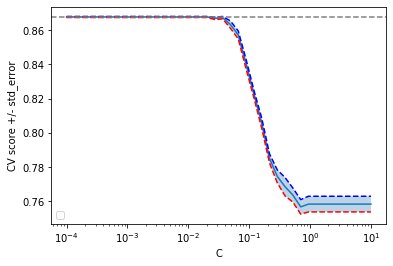

In [15]:
# Creates log space between 10^-4 to 10^1 for C values
ces = np.logspace(-4, 1, 70)
# Stores these values as the C parameters to be used in grid search
tuned_parameters = [{'C': ces}]
n_folds = 5
# Creates a Grid Search CV component using tuned params, SVC created before
clf = GridSearchCV(svc, tuned_parameters, cv = n_folds, refit = True, verbose = 10)
clf.fit(train_x, train_y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(6,4)
plt.semilogx(ces, scores)
# Plotting standard deviation error, red and blue lines on graph to show +-
std_error = scores_std / np.sqrt(n_folds) 
plt.semilogx(ces, scores + std_error, 'b--')
plt.semilogx(ces, scores - std_error, 'r--')

plt.fill_between(ces, scores + std_error, scores - std_error, alpha = 0.3)
# Labels axis
plt.ylabel('CV score +/- std_error')
plt.xlabel('C')
# Creates grey dotted line showing maximum.
plt.axhline(np.max(scores), linestyle='--', color = '.5')
# Prints the maximum score, at which value of C.
print(np.max(scores))
print("C values between:", ces[0], "and", ces[-1])
print("x value for max y val:", ces[scores.argmax()])
# Shows Graph
plt.legend(loc="best")
plt.show()

## Learning Curve

[learning_curve] Training set sizes: [ 10  25  50  75 100 125 150 175 200 225 250 275 300 325]
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.427), total=   0.0s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.779), total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=1.000, test=0.846), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.836), total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=1.000, test=0.846), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.840), total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.987, test=0.848), total=   0.2s
[CV]  ................................................................
[CV] ................ , score=(train=0.983, test=0.852), total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.970, test=0.860), total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.960, test=0.860), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.984, test=0.858), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.975, test=0.860), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.987, test=0.848), total=   0.4s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.985, test=0.844), total=   0.4s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.868), total=   0.0s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.866), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.842), total=   0.1s

F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war


[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.860), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.990, test=0.860), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=0.984, test=0.856), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.987, test=0.844), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.971, test=0.842), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.965, test=0.852), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.951, test=0.854), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.862), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.945, test=0.864), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.943, test=0.858), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.854), total=   0.3s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.870), total=   0.0s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.860), total=   0.0s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.830), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[CV] ................ , score=(train=1.000, test=0.860), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=0.990, test=0.864), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.984, test=0.858), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=0.987, test=0.860), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.971, test=0.852), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.965, test=0.852), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.951, test=0.858), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.864), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.945, test=0.864), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.943, test=0.862), total=   0.4s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.864), total=   0.3s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.868), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.868), total=   0.0s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[CV] ................ , score=(train=1.000, test=0.856), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.866), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.990, test=0.860), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=0.984, test=0.860), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.987, test=0.848), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.971, test=0.846), total=   0.2s
[CV]  ................................................................
[CV] ................ , score=(train=0.965, test=0.850), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.951, test=0.858), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.862), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.945, test=0.864), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.943, test=0.862), total=   0.4s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.862), total=   0.4s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.866), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.868), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[CV] ................ , score=(train=1.000, test=0.834), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=1.000, test=0.860), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.990, test=0.866), total=   0.1s
[CV]  ................................................................
[CV] ................ , score=(train=0.984, test=0.862), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.987, test=0.852), total=   0.1s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.971, test=0.854), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.965, test=0.848), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.951, test=0.856), total=   0.2s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.858), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.945, test=0.862), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.943, test=0.858), total=   0.3s
[CV]  ................................................................


F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ................ , score=(train=0.948, test=0.856), total=   0.3s


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   16.2s finished


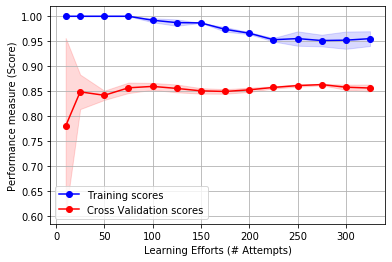

In [16]:
# Generates Learning curve, using SVC fitted with best params, and training sizes ranging between 10-150
training_sizes, training_scores, testing_scores = learning_curve(svc, train_x, train_y, cv=5, train_sizes=[10,25,50,75,100,125,150,175,200,225,250,275,300,325], verbose=10)
# Plotting the Learning Curve :) #
# X axis
plt.xlabel("Learning Efforts (# Attempts)")
# Y axis
plt.ylabel("Performance measure (Score)")
training_scores_mean = np.mean(training_scores, axis=1)
training_scores_std = np.std(training_scores, axis=1)
testing_scores_mean = np.mean(testing_scores, axis=1)
testing_scores_std = np.std(testing_scores, axis=1)
# Graph shown in grid mode, helps show exact Y values
plt.grid()
# Blue line colour for Training score values.
plt.fill_between(training_sizes, (training_scores_mean - training_scores_std),
                   (training_scores_std + training_scores_mean), alpha=0.15,
                     color="b")
# Red line colour for cross validation score values.
plt.fill_between(training_sizes, (testing_scores_mean - testing_scores_std),
                   (testing_scores_std + testing_scores_mean), alpha=0.15, color="r")
# Creates colour key for the graph
plt.plot(training_sizes, training_scores_mean, 'o-', color="b",
             label="Training scores")
plt.plot(training_sizes, testing_scores_mean, 'o-', color="r",
             label="Cross Validation scores")
# Sets location to best within wrapper (legend)
plt.legend(loc="best")
plt.show()

In [17]:
# Writing predictions created by classifer to a file called "output" in CSV format.
def write_preds(preds, filename):
    pd.DataFrame({"ID": list(range(1,len(preds)+1)), "Prediction": preds}).to_csv(filename, index=False, header=True)

write_preds(preds, "outputscale1.csv")